# DSI Capstone
## Predicting Hospital Survey Results

My goal for the capstone is to determin if the way we measure quality in Medicare Hospitals have any impact on how Patients rate their care in the Hospitals. 

I will be combining separate reports of quality metrics that rate their ER time and effective care, Infection rates, Ownership type, inpatient psych care, average spend per patient, and outpatient imaging services per hospital.   

The data for these metrics will be taken from annual reports from https://data.medicare.gov/ for the past 4 years.

This data will be used to predict what Patient will rate the "Summary star rating" on their Hospital Survey.





In [11]:
#!pip install pymysql

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
from pandas.io import sql
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
host="cms.ctvgwsug2thu.us-west-1.rds.amazonaws.com"
port=3306
dbname="cms"
user=""
password=""

conn = pymysql.connect(host, user=user,port=port,
                           passwd=password, db=dbname)

# Loading data from SQL database


In [4]:
survey = pd.read_sql(
'''SELECT h.`Provider ID`, h.`ZIP Code`, h.year, h.`Patient Survey Star Rating` ,p.`Score` as spend_score  
FROM hospital_survey as h  
LEFT JOIN pat_spend as p on h.`Provider ID` = p.`Provider ID` and h.year = p.year  
WHERE h.`HCAHPS Measure ID` = "H_STAR_RATING" 
AND h.`Patient Survey Star Rating` <> "Not Available" 
GROUP BY 1,2,3;''', con = conn)

In [88]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13988 entries, 0 to 13987
Data columns (total 5 columns):
Provider ID                   13988 non-null object
ZIP Code                      13988 non-null object
year                          13988 non-null int64
Patient Survey Star Rating    13988 non-null int64
spend_score                   11943 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 546.5+ KB


In [89]:
survey.replace("Not Available", np.NaN, inplace = True)
survey['Patient Survey Star Rating'] = survey['Patient Survey Star Rating'].astype(int)
survey['spend_score'] = survey['spend_score'].astype(float)

(array([ 254., 2283., 5871., 4835.,  745.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

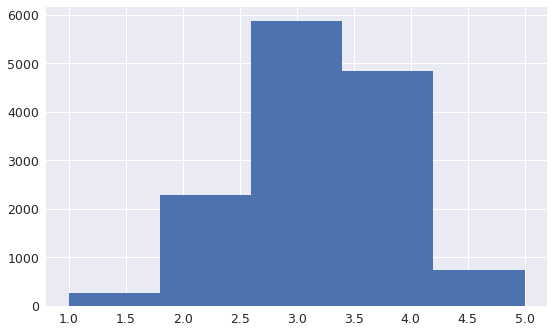

In [90]:
plt.hist(survey['Patient Survey Star Rating'],bins = 5)

In [35]:
te_score = pd.read_sql('''
SELECT Provider_ID, `ZIP Code`, year, Measure_ID, Score as te_score from timeandeff
where Score <> "Not Available"
and year <> 2015
''', con = conn)
te_score.head()

,Provider_ID,ZIP Code,year,Measure_ID,te_score
0,010001,36301,2018,ED_1b,237
1,010001,36301,2018,ED_2b,74
2,010001,36301,2018,EDV,"High (40,000 - 59,999 patients annually)"
3,010001,36301,2018,IMM_2,92
4,010001,36301,2018,IMM_3_OP_27_FAC_ADHPCT,86


In [36]:
te_score['te_score'] = te_score['te_score'].replace('Very High (60,000+ patients annually)', 4)
te_score['te_score'] = te_score['te_score'].replace('High (40,000 - 59,999 patients annually)', 3)
te_score['te_score'] = te_score['te_score'].replace('Medium (20,000 - 39,999 patients annually)', 2)
te_score['te_score'] = te_score['te_score'].replace('Low (0 - 19,999 patients annually)', 1)

In [58]:
te_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13370 entries, 0 to 13369
Data columns (total 28 columns):
Provider_ID               13370 non-null object
ZIP Code                  13370 non-null object
year                      13370 non-null int64
EDV                       10502 non-null float64
ED_1b                     11234 non-null float64
ED_2b                     11185 non-null float64
IMM_2                     12272 non-null float64
IMM_3_OP_27_FAC_ADHPCT    12497 non-null float64
OP_1                      253 non-null float64
OP_18b                    11223 non-null float64
OP_18c                    2781 non-null float64
OP_2                      253 non-null float64
OP_20                     11242 non-null float64
OP_21                     10550 non-null float64
OP_22                     10495 non-null float64
OP_23                     4156 non-null float64
OP_29                     8486 non-null float64
OP_30                     8259 non-null float64
OP_31                

In [37]:
te_score['te_score'] = te_score['te_score'].astype(float)

In [38]:
te_score = pd.pivot_table(te_score, values = 'te_score', index = ['Provider_ID','ZIP Code','year'], columns = 'Measure_ID').reset_index()
te_score.head()

Measure_ID,Provider_ID,ZIP Code,year,EDV,ED_1b,ED_2b,IMM_2,IMM_3_OP_27_FAC_ADHPCT,OP_1,OP_18b,...,OP_31,OP_33,OP_3b,OP_4,OP_5,PC_01,SEP_1,STK_4,VTE_5,VTE_6
0,010001,36301,2016,3.0,270.0,74.0,95.0,81.0,NaN,201.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,64.0,83.0,0.0
1,010001,36301,2017,3.0,286.0,99.0,95.0,86.0,NaN,198.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,81.0,81.0,0.0
2,010001,36301,2018,3.0,237.0,74.0,92.0,86.0,NaN,163.0,...,NaN,NaN,NaN,NaN,NaN,3.0,62.0,NaN,NaN,0.0
3,010005,35957,2016,4.0,242.0,71.0,97.0,83.0,NaN,113.0,...,NaN,NaN,NaN,99.0,13.0,1.0,NaN,NaN,100.0,NaN
4,010005,35957,2017,4.0,240.0,72.0,97.0,80.0,NaN,113.0,...,NaN,NaN,NaN,98.0,14.0,2.0,NaN,NaN,94.0,NaN


In [10]:
hospital = pd.read_sql('''
SELECT `Provider ID`, `ZIP Code`,`Hospital Type`,`Hospital Ownership`,`year` 
FROM hospital
;
''', con = conn)
hospital.head()

,Provider ID,ZIP Code,Hospital Type,Hospital Ownership,year
0,010001,36301,Acute Care Hospitals,Government - Hospital District or Authority,2018
1,010005,35957,Acute Care Hospitals,Government - Hospital District or Authority,2018
2,010006,35631,Acute Care Hospitals,Government - Hospital District or Authority,2018
3,010007,36467,Acute Care Hospitals,Voluntary non-profit - Private,2018
4,010008,36049,Acute Care Hospitals,Proprietary,2018


In [313]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 5 columns):
Provider ID           19221 non-null object
ZIP Code              19221 non-null object
Hospital Type         19221 non-null object
Hospital Ownership    19221 non-null object
year                  19221 non-null int64
dtypes: int64(1), object(4)
memory usage: 750.9+ KB


In [11]:
hospital = pd.get_dummies(hospital,columns = ['Hospital Type', 'Hospital Ownership'])

In [316]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 18 columns):
Provider ID                                                       19221 non-null object
ZIP Code                                                          19221 non-null object
year                                                              19221 non-null int64
Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION                19221 non-null uint8
Hospital Type_Acute Care Hospitals                                19221 non-null uint8
Hospital Type_Childrens                                           19221 non-null uint8
Hospital Type_Critical Access Hospitals                           19221 non-null uint8
Hospital Ownership_Government - Federal                           19221 non-null uint8
Hospital Ownership_Government - Hospital District or Authority    19221 non-null uint8
Hospital Ownership_Government - Local                             19221 non-null uint8
Hospital Ownership_

In [12]:
infections = pd.read_sql('''
select `Provider ID`, `ZIP Code`, `year` , `Measure ID`, `Score` from infections
where Score not in ("Not Available", "-")
''',con = conn)
                        

In [59]:
infections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 51 columns):
Provider ID         15120 non-null object
ZIP Code            15120 non-null object
year                15120 non-null int64
HAI_1_CI_LOWER      6451 non-null float64
HAI_1_CI_UPPER      7758 non-null float64
HAI_1_DOPC_DAYS     12343 non-null float64
HAI_1_ELIGCASES     12343 non-null float64
HAI_1_NUMERATOR     12343 non-null float64
HAI_1_SIR           7758 non-null float64
HAI_1a_CI_LOWER     1510 non-null float64
HAI_1a_CI_UPPER     1996 non-null float64
HAI_1a_DOPC_DAYS    1996 non-null float64
HAI_1a_ELIGCASES    1996 non-null float64
HAI_1a_NUMERATOR    1996 non-null float64
HAI_1a_SIR          1996 non-null float64
HAI_2_CI_LOWER      5388 non-null float64
HAI_2_CI_UPPER      6639 non-null float64
HAI_2_DOPC_DAYS     9660 non-null float64
HAI_2_ELIGCASES     9660 non-null float64
HAI_2_NUMERATOR     9660 non-null float64
HAI_2_SIR           6639 non-null float64
HAI_2a_

In [13]:
infections['Score'] = infections['Score'].astype(float)

In [14]:
infections = pd.pivot_table(infections, values = 'Score', index = ['Provider ID','ZIP Code','year'], columns = 'Measure ID').reset_index()

In [91]:
survey_te = pd.merge(survey, te_score,  how='left', left_on=['Provider ID','year'], right_on = ['Provider_ID','year'])
survey_te.head()

,Provider ID,ZIP Code_x,year,Patient Survey Star Rating,spend_score,Provider_ID,ZIP Code_y,EDV,ED_1b,ED_2b,...,OP_31,OP_33,OP_3b,OP_4,OP_5,PC_01,SEP_1,STK_4,VTE_5,VTE_6
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,64.0,83.0,0.0
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,81.0,81.0,0.0
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,NaN,NaN,NaN,NaN,NaN,3.0,62.0,NaN,NaN,0.0
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
survey_te.columns = ['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6']

In [93]:
survey_te_hospital = pd.merge(survey_te, hospital, how = 'left', left_on = ['Provider ID','year'], right_on = ['Provider ID', 'year'])
survey_te_hospital.head()


,Provider ID,ZIP Code_survey,year,Patient Survey Star Rating,spend_score,Provider_ID_te,ZIP Code_y,EDV,ED_1b,ED_2b,...,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Government Federal,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,1,0,0,0,0,0,0,0,0,0
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,1,0,0,0,0,0,0,0,0,0
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,1,0,0,0,0,0,0,0,0,0
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [94]:
survey_te_hospital.columns = ['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'ZIP Code_hospital', 'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Voluntary non-profit - Private']

In [95]:
survey_te_hos_infect = pd.merge(survey_te_hospital, infections,  how='left', left_on=['Provider ID','year'], right_on = ['Provider ID','year'])
survey_te_hos_infect.head()

,Provider ID,ZIP Code_survey,year,Patient Survey Star Rating,spend_score,Provider_ID_te,ZIP Code_y,EDV,ED_1b,ED_2b,...,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_CI_LOWER,HAI_6_CI_UPPER,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,98235.0,7.986,8.0,1.002,0.650,1.139,94861.0,56.404,49.0,0.869
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,97762.0,4.965,8.0,1.611,0.224,0.493,97762.0,73.755,25.0,0.339
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,100032.0,5.743,5.0,0.871,0.502,0.881,99655.0,72.932,49.0,0.672
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,36649.0,1.460,3.0,2.055,0.114,0.691,36721.0,16.029,5.0,0.312


In [96]:
survey_te_hos_infect.columns

Index(['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'ZIP Code_hospital',
       'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_V

In [97]:
survey_te_hos_infect.drop(columns = ['Provider_ID_te', 'ZIP Code_hospital', 'ZIP Code'], inplace = True)

In [98]:
len(survey_te_hos_infect.columns)

94

In [72]:
survey_te_hos_infect.columns

Index(['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b', 'IMM_2',
       'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2', 'OP_20',
       'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33', 'OP_3b',
       'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospita

In [51]:
 survey_te_hos_infect.isnull().sum(axis=1)

0        32
1        58
2        23
3        24
4        32
5        58
6        26
7        23
8        26
9        58
10       25
11       26
12       69
13       60
14       41
15       39
16       26
17       57
18       26
19       25
20       58
21       58
22       36
23       32
24       32
25       59
26       25
27       25
28       46
29       57
         ..
13958    35
13959    35
13960    36
13961    25
13962    25
13963    46
13964    40
13965    32
13966    30
13967    44
13968    39
13969    27
13970    25
13971    43
13972    41
13973    44
13974    35
13975    34
13976    46
13977    33
13978    36
13979    47
13980    39
13981    36
13982    47
13983    39
13984    40
13985    42
13986    36
13987    54
Length: 13988, dtype: int64

In [25]:
#!pip install missingno
import missingno as msno

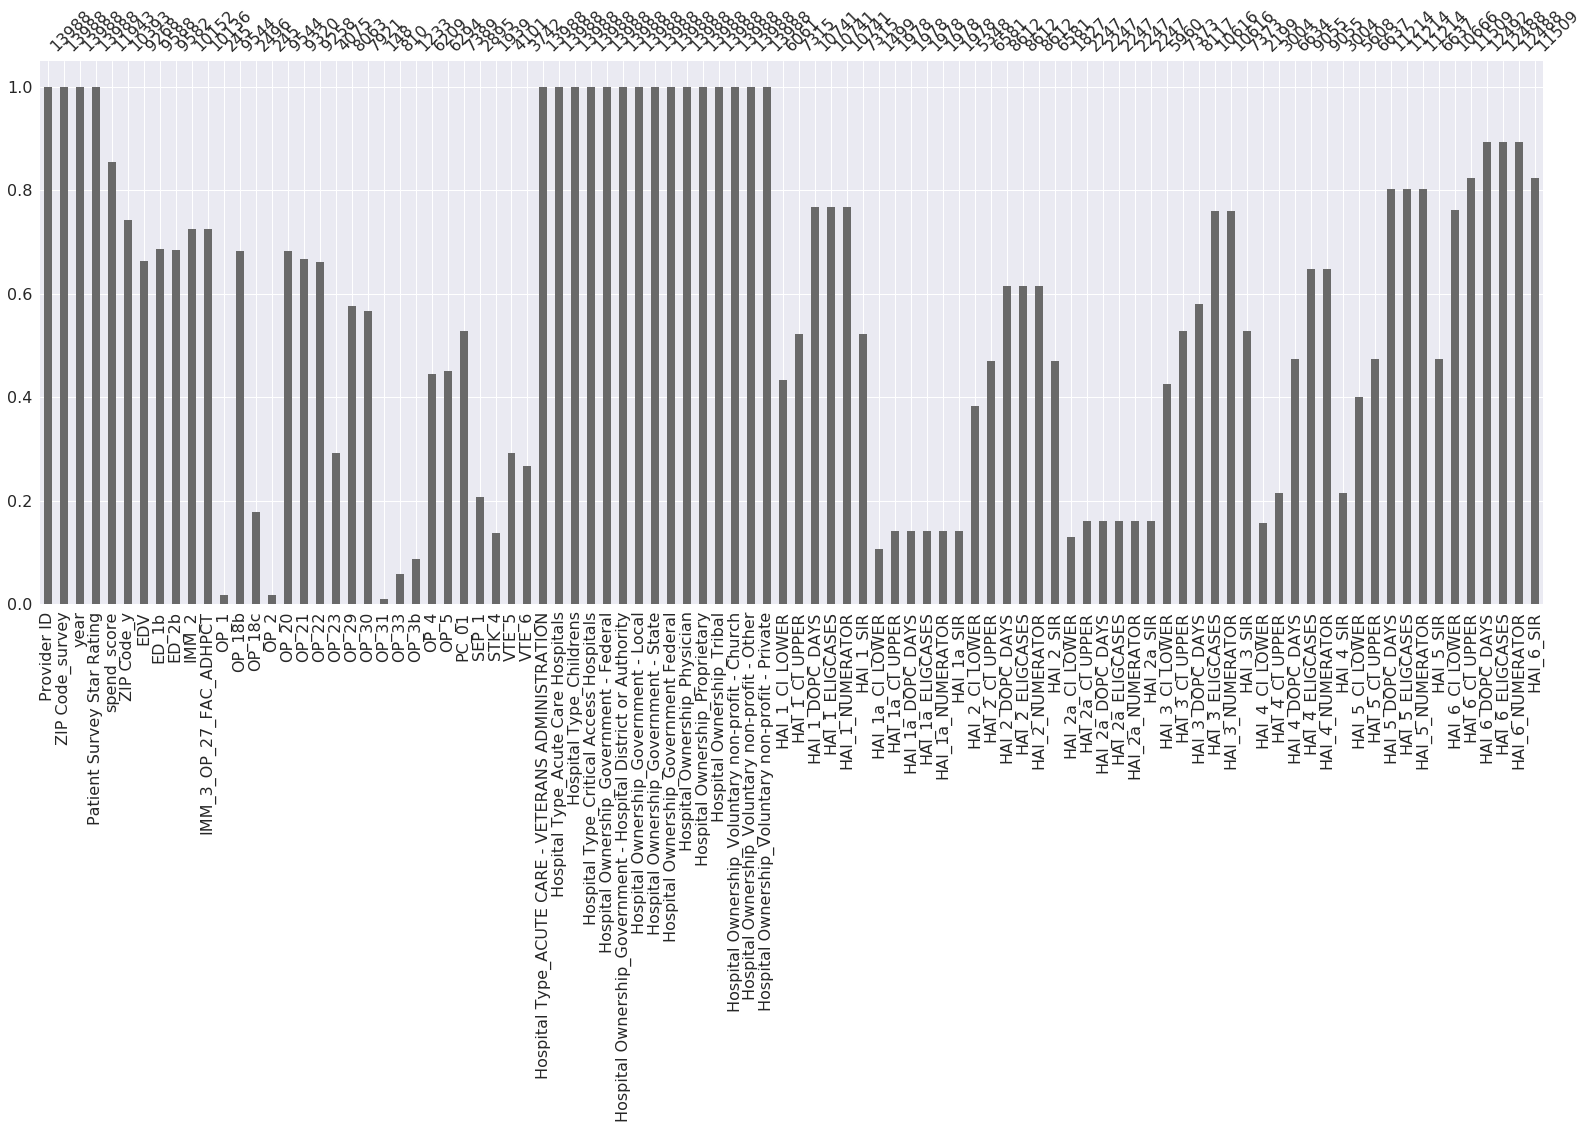

In [73]:
msno.bar(survey_te_hos_infect)

### Dropping Columns with bad fill rates

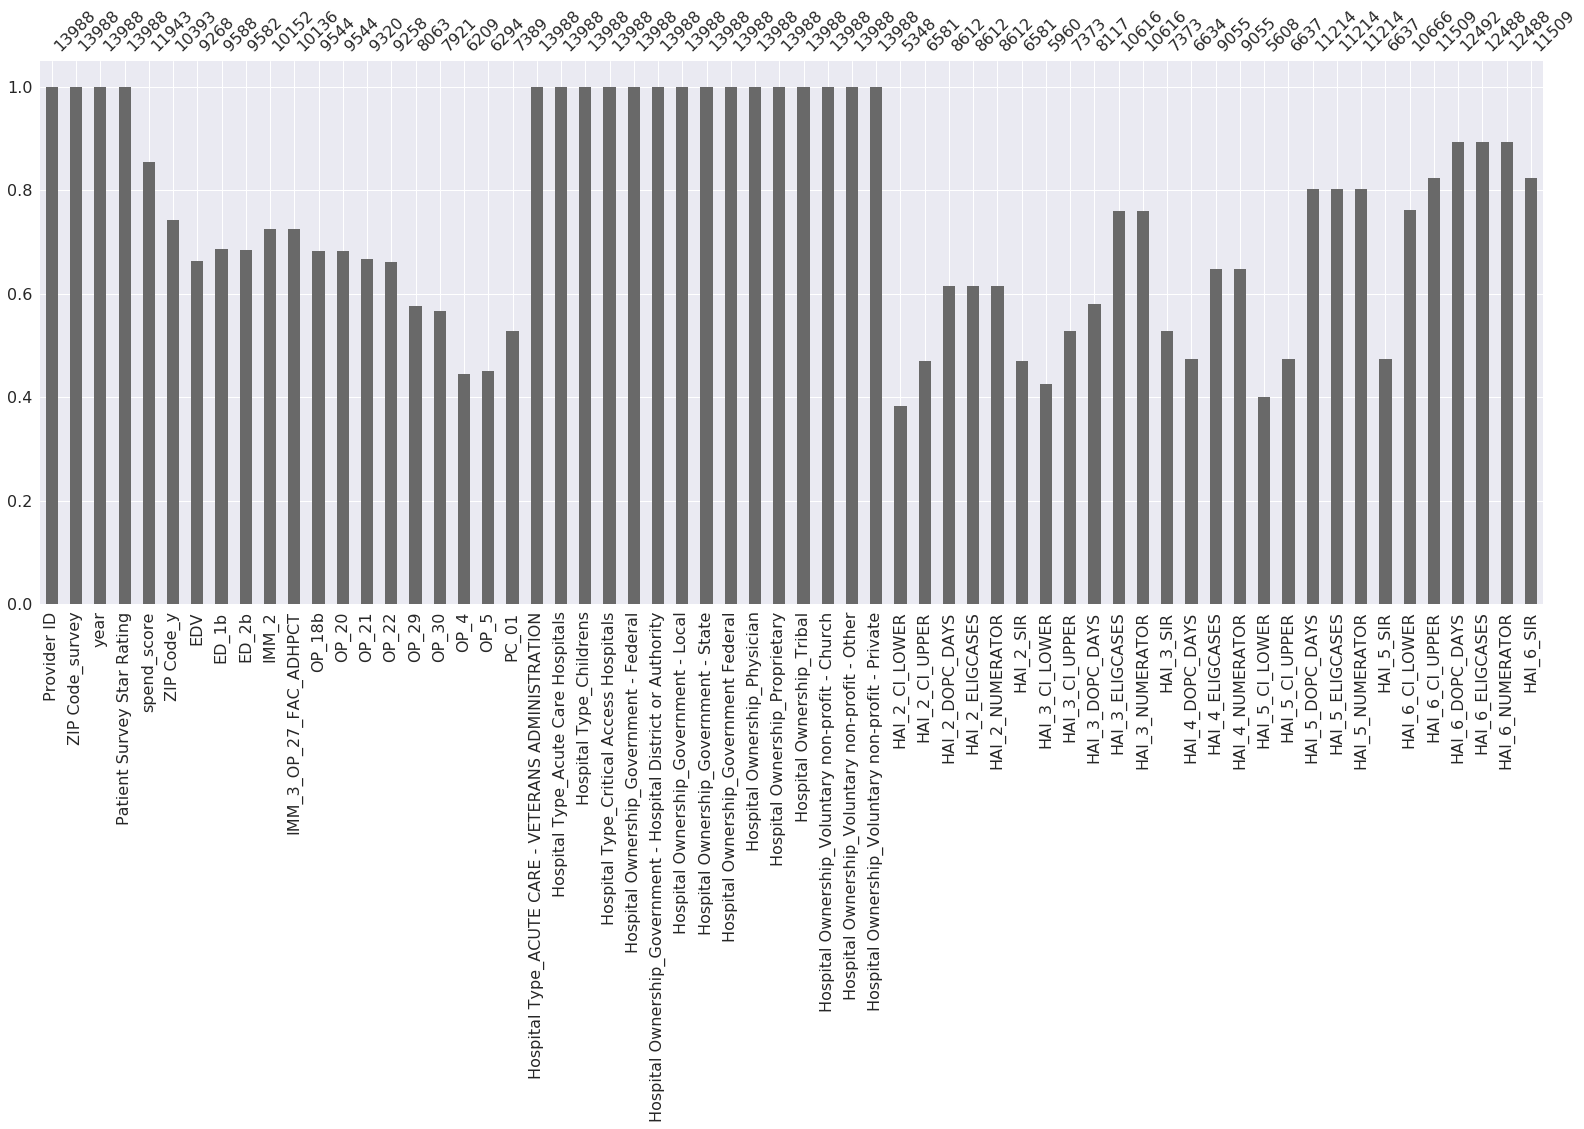

In [142]:
msno.bar(survey_te_hos_infect.drop(columns = ['OP_1','OP_2','OP_18c','OP_23','OP_31','OP_33','OP_3b','SEP_1', 'STK_4',
'VTE_5', 'VTE_6','HAI_1_CI_LOWER','HAI_1_CI_UPPER', 'HAI_1_DOPC_DAYS', 'HAI_1_ELIGCASES','HAI_1a_CI_LOWER',
'HAI_1a_CI_UPPER','HAI_1a_DOPC_DAYS','HAI_1a_ELIGCASES','HAI_1a_NUMERATOR','HAI_1a_SIR','HAI_1_NUMERATOR', 
'HAI_1_SIR','HAI_2a_CI_LOWER','HAI_2a_CI_UPPER', 'HAI_2a_DOPC_DAYS', 'HAI_2a_ELIGCASES',
'HAI_2a_NUMERATOR', 'HAI_2a_SIR', 'HAI_4_CI_LOWER', 'HAI_4_CI_UPPER','HAI_4_SIR']))

In [147]:
# creating new dataframe with dropped columns and missing data filled with 0
survey_te_hos_infect_zeros = survey_te_hos_infect.fillna(0).drop(columns = ['OP_1','OP_2','OP_18c','OP_23','OP_31','OP_33','OP_3b','SEP_1', 'STK_4',
'VTE_5', 'VTE_6','HAI_1_CI_LOWER','HAI_1_CI_UPPER', 'HAI_1_DOPC_DAYS', 'HAI_1_ELIGCASES','HAI_1a_CI_LOWER',
'HAI_1a_CI_UPPER','HAI_1a_DOPC_DAYS','HAI_1a_ELIGCASES','HAI_1a_NUMERATOR','HAI_1a_SIR','HAI_1_NUMERATOR', 
'HAI_1_SIR','HAI_2a_CI_LOWER','HAI_2a_CI_UPPER', 'HAI_2a_DOPC_DAYS', 'HAI_2a_ELIGCASES',
'HAI_2a_NUMERATOR', 'HAI_2a_SIR', 'HAI_4_CI_LOWER', 'HAI_4_CI_UPPER','HAI_4_SIR'])

In [148]:
survey_te_hos_infect_zeros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13988 entries, 0 to 13987
Data columns (total 62 columns):
Provider ID                                                       13988 non-null object
ZIP Code_survey                                                   13988 non-null object
year                                                              13988 non-null int64
Patient Survey Star Rating                                        13988 non-null int64
spend_score                                                       13988 non-null float64
ZIP Code_y                                                        13988 non-null object
EDV                                                               13988 non-null float64
ED_1b                                                             13988 non-null float64
ED_2b                                                             13988 non-null float64
IMM_2                                                             13988 non-null float64
IMM_3_OP

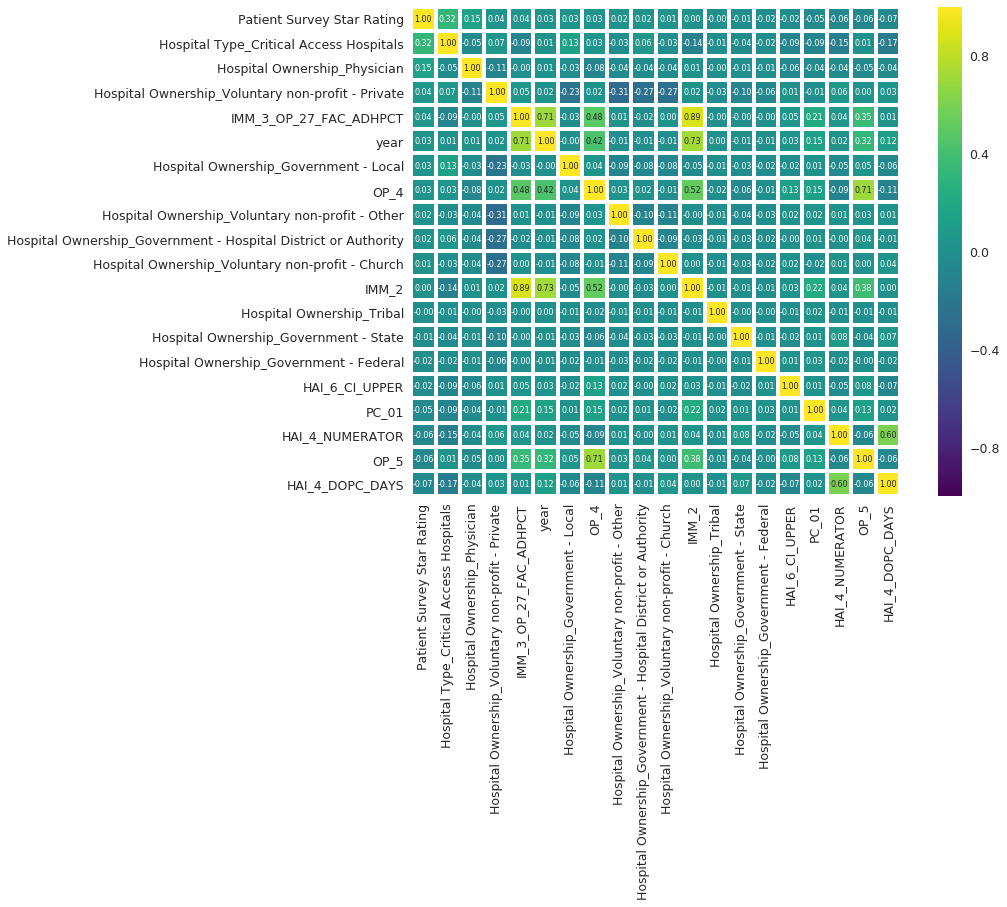

In [163]:
corrlist = survey_te_hos_infect_zeros.corr()

k = 20
cols = corrlist.nlargest(k, 'Patient Survey Star Rating')['Patient Survey Star Rating'].index
cm = np.corrcoef(survey_te_hos_infect_zeros[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, linewidth = 3,
                 yticklabels=cols.values, xticklabels=cols.values, cmap = 'viridis', linecolor = 'white')
plt.show()

In [151]:
logreg = LogisticRegression()
ss = StandardScaler()

X = survey_te_hos_infect_zeros.drop(columns = ['Patient Survey Star Rating','ZIP Code_survey','year','ZIP Code_y'])
       
y = survey_te_hos_infect_zeros['Patient Survey Star Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [152]:
from imblearn.over_sampling import SMOTE

In [153]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [154]:
sm = SMOTE()
x_train_res, y_train_res = sm.fit_sample(X_train_scaled, y_train)


(array([4352.,    0., 4352.,    0.,    0., 4352.,    0., 4352.,    0.,
        4352.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

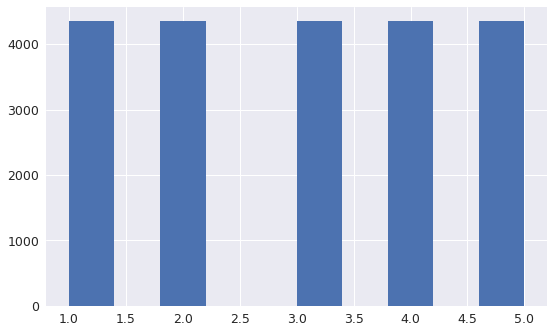

In [155]:
plt.hist(y_train_res)

### Logistic Regression

In [156]:
model = logreg.fit(x_train_res,y_train_res)
print("Train: ",model.score(x_train_res, y_train_res))
print("Test: ", model.score(X_test_scaled, y_test))

Train:  0.5852481617647058
Test:  0.41292536459822704


Text(0.5, 1.0, 'Logistic Regression Coefficients')

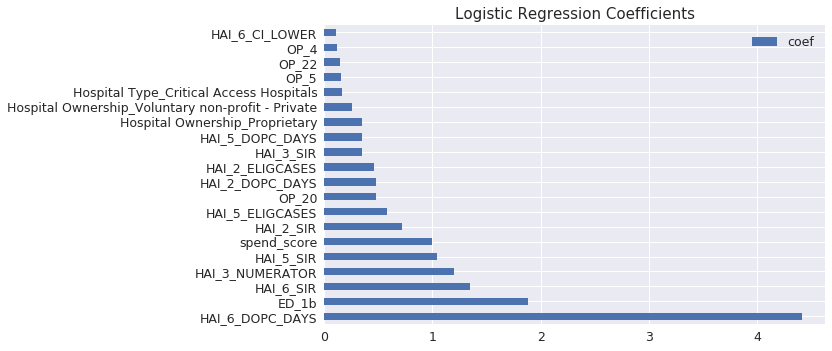

In [157]:
coefs = pd.DataFrame(logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(20).plot(kind = 'barh')
plt.title('Logistic Regression Coefficients')

### Random Forrest

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators= 100)
rf.fit(x_train_res, y_train_res)

print("Train: ", rf.score(x_train_res, y_train_res))
print("Test: ", rf.score(X_test_scaled, y_test))


Train:  0.9997702205882353
Test:  0.5790677723763226


### Support Vector Classifier

In [159]:
from sklearn.svm import SVC

scv = SVC()

scv.fit(x_train_res, y_train_res)
print("Train: ", scv.score(x_train_res, y_train_res))
print("Test: ", scv.score(X_test_scaled, y_test))

Train:  0.7159007352941177
Test:  0.4741206748641693


### KNN

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train_scaled,y_train)

print("Train: ", knn.score(X_train_scaled, y_train))
print("Test: ", knn.score(X_test_scaled, y_test))


Train:  0.6404537222381088
Test:  0.49385187303402917
